# Text classification using CNN

**Task is sentiment analysis**

Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите какой результат вы получили? Что помогло вам улучшить её точность?

In [1]:
!pip install -q pymorphy2
!pip install -q stop_words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import random
import torch
import torch.nn as nn
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
from torch.utils.data import DataLoader, Dataset

# Dataset loading

In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_val = pd.read_csv("val.csv")

In [5]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [6]:
df_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не полу..."
2,204152,"Хочу лето только ради того, что бы направить н..."
3,204153,RT @RonyLiss: @colf_ne блин((\nа я шипперила Ф...
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое во..."


In [7]:
df_val.head()

,id,text,class
0,181467,RT @TukvaSociopat: Максимальный репост! ))) #є...,1
1,181468,чтоб у меня з.п. ежегодно индексировали на инд...,0
2,181469,@chilyandlime нехуя мне не хорошо !!! :((((,0
3,181470,"@inafish нее , когда ногами ахахах когда?ахаха...",0
4,181471,"Хочу сделать как лучше, а получаю как всегда. :(",0


In [8]:
max_words = 2000
max_len = 15
num_classes = 1

# Training
epochs = 25
batch_size = 256
print_batch_n = 100

# Preprocessing

In [9]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [10]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [11]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Отфильтруем данные и соберём в корпус N наиболее частых токенов

In [12]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [13]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [16]:
tokens_filtered_top[:20]

['rt',
 'd',
 'хотеть',
 'знать',
 'ян',
 'мочь',
 'новый',
 'любить',
 'завтра',
 'мой',
 'хороший',
 'делать',
 'день',
 'смотреть',
 'вообще',
 'думать',
 'идти',
 'иня',
 'блин',
 'самый']

In [17]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [18]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0] * (maxlen-len(result))
    return padding + result[-maxlen:]

In [19]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["text"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["text"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["text"]], dtype=np.int32)

In [20]:
x_train.shape

(181467, 20)

In [22]:
x_train[13]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 125,  20,  11,  27], dtype=int32)

In [23]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [24]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        #                       B  F  L
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)

        return output

In [25]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [26]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()


train_dataset = DataWrapper(x_train, df_train['class'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['class'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # data = data.cuda()
        # target = target.cuda()

        # compute output
        output = model(data)

        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()

        optimizer.step()

        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 305409
Train epoch 1/20
Step 0: loss=0.7343103885650635
Step 100: loss=0.5900409817695618
Step 200: loss=0.5896226167678833
Step 300: loss=0.5395540595054626
Train epoch 2/20
Step 0: loss=0.5298414826393127
Step 100: loss=0.5457838773727417
Step 200: loss=0.5388907194137573
Step 300: loss=0.5663456916809082
Train epoch 3/20
Step 0: loss=0.5029072165489197
Step 100: loss=0.5101633071899414
Step 200: loss=0.5240796208381653
Step 300: loss=0.526673436164856
Train epoch 4/20
Step 0: loss=0.4402509033679962
Step 100: loss=0.5537197589874268
Step 200: loss=0.5059614777565002
Step 300: loss=0.49713876843452454
Train epoch 5/20
Step 0: loss=0.4312606751918793
Step 100: loss=0.46398255228996277
Step 200: loss=0.4680840075016022
Step 300: loss=0.5139080286026001
Train epoch 6/20
Step 0: loss=0.403085291385

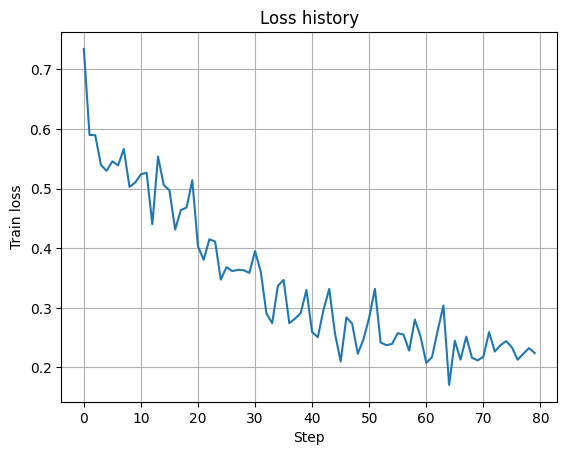

In [27]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);

In [28]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)